In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2025-08-13 02:22:38--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.9.173, 52.217.167.144, 52.216.200.37, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.9.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.6MB/s    in 1.0s    

2025-08-13 02:22:40 (13.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [2]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
import os

fname = '/content/jena_climate_2009_2016.csv'

with open(fname) as f:
  data = f.read()

lines   = data.split("\n")
headers = lines[0].split(",")
lines   = lines[1:]
print(headers)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
print(lines[0])
print(lines[1])
print(lines[2])

01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60


In [5]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data    = np.zeros((len(lines), len(headers) - 1))

for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

print(f'Temperature target shape: {temperature.shape}')
print(f'Temperature target first sample: {temperature[0]}')
print(f'\nRaw data shape: {raw_data.shape}')
print(f'Raw data first sample: {raw_data[0]}')

Temperature target shape: (420451,)
Temperature target first sample: -8.02

Raw data shape: (420451, 14)
Raw data first sample: [ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


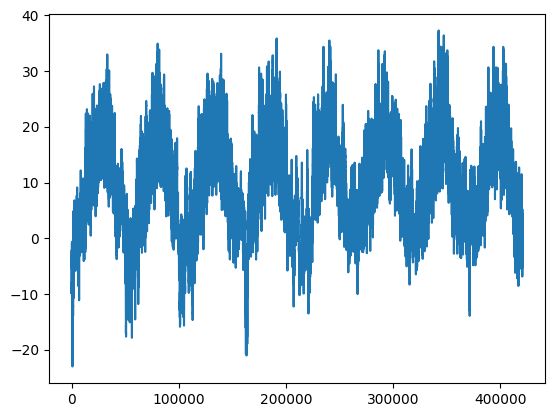

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(len(temperature)), temperature)

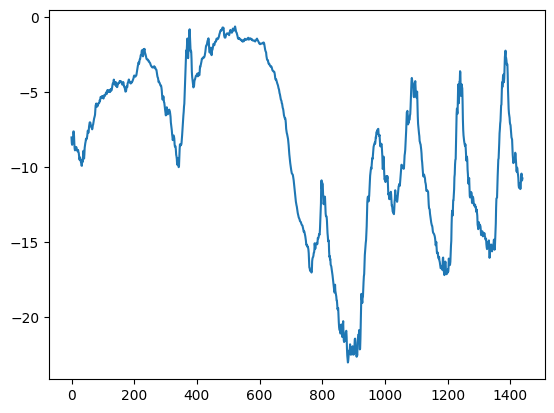

In [7]:
plt.plot(range(1440), temperature[:1440])

In [8]:
num_train_samples = int(0.5 * len(temperature))
num_val_samples   = int(0.25 * len(temperature))
num_test_samples  = len(temperature) - num_train_samples - num_val_samples

print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of testing samples: {num_test_samples}")

Number of training samples: 210225
Number of validation samples: 105112
Number of testing samples: 105114


In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

print(f"Raw data first sample after standardizations: \n{raw_data[0]}")

Raw data first sample after standardizations: 
[ 0.91365151 -1.92064015 -1.97449272 -1.86625827  1.04801712 -1.29131928
 -1.46715535 -0.78234525 -1.47012583 -1.4720352   2.12415558 -0.73016651
 -0.77935289 -0.28119316]


In [10]:
from tensorflow import keras

sampling_rate   = 6
sequence_length = 120
delay           = sampling_rate * (sequence_length + 24 - 1)
batch_size      = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    data            = raw_data[:-delay],
    targets         = temperature[delay:],
    sampling_rate   = sampling_rate,
    sequence_length = sequence_length,
    shuffle         = True,
    batch_size      = batch_size,
    start_index     = 0,
    end_index       = num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data            = raw_data[:-delay],
    targets         = temperature[delay:],
    sampling_rate   = sampling_rate,
    sequence_length = sequence_length,
    shuffle         = True,
    batch_size      = batch_size,
    start_index     = num_train_samples,
    end_index       = num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data            = raw_data[:-delay],
    targets         = temperature[delay:],
    sampling_rate   = sampling_rate,
    sequence_length = sequence_length,
    shuffle         = True,
    batch_size      = batch_size,
    start_index     = num_train_samples + num_val_samples)

for samples, targets in train_dataset:
  print("Sample shape", samples.shape)
  print("Targets shape", targets.shape)
  break

Sample shape (256, 120, 14)
Targets shape (256,)


In [11]:
def evaluate_naive_method(dataset):
  total_abs_err = 0
  samples_seen  = 0
  for samples, targets in dataset:
    preds          = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen  += samples.shape[0]
  return total_abs_err/samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [12]:
# from tensorflow import keras
from tensorflow.keras import layers

# n_features = 14

inputs  = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x       = layers.GlobalAveragePooling1D()(inputs)
x       = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model   = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras" ,save_best_only=True)
]

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

history = model.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset,
          callbacks=callbacks)

model = keras.models.load_model('jena_dense.keras')
print(f"Test MAE {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - loss: 81.7160 - mae: 7.1960 - val_loss: 22.0746 - val_mae: 3.7010
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 22.7895 - mae: 3.8245 - val_loss: 20.5562 - val_mae: 3.5907
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 21.9250 - mae: 3.7428 - val_loss: 20.5481 - val_mae: 3.5880
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 21.7609 - mae: 3.7268 - val_loss: 20.4124 - val_mae: 3.5701
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 21.6705 - mae: 3.7178 - val_loss: 20.5225 - val_mae: 3.5735
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 21.5849 - mae: 3.7116 - val_loss: 20.5155 - val_mae: 3.5782
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - loss: 21.5025 - mae: 3.7045 - val_loss: 20.6262 - val_mae: 3.5944
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - loss: 21.3456 - mae: 3.6916 - val_loss: 20.4683 - val_mae: 3.5785
Epoch 9/10
819/819 ━━━━━

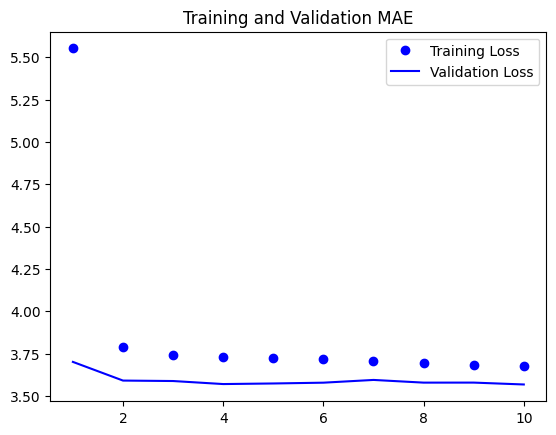

In [13]:
loss     = history.history['mae']
val_loss = history.history['val_mae']
epochs   = range(1, len(loss) +1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

In [14]:
inputs  = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x       = layers.Conv1D(8, 24, activation='relu')(inputs)
x       = layers.MaxPooling1D(2)(x)
x       = layers.Conv1D(8, 12, activation='relu')(x)
x       = layers.MaxPooling1D(2)(x)
x       = layers.Conv1D(8, 6, activation='relu')(x)
x       = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model   = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv1d.keras" ,save_best_only=True)
]

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

history = model.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset,
          callbacks=callbacks)

model = keras.models.load_model('jena_conv1d.keras')
print(f"Test MAE {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - loss: 34.0354 - mae: 4.4247 - val_loss: 17.8979 - val_mae: 3.3427
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 15.8259 - mae: 3.1671 - val_loss: 16.3546 - val_mae: 3.1606
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - loss: 14.4623 - mae: 3.0201 - val_loss: 13.7185 - val_mae: 2.9100
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 13.4774 - mae: 2.9062 - val_loss: 16.4169 - val_mae: 3.1612
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - loss: 12.7415 - mae: 2.8189 - val_loss: 14.0632 - val_mae: 2.9577
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 12.2512 - mae: 2.7622 - val_loss: 13.1512 - val_mae: 2.8488
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - loss: 11.8094 - mae: 2.7129 - val_loss: 12.9529 - val_mae: 2.8351
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 11.4056 - mae: 2.6632 - val_loss: 13.7104 - val_mae: 2.8959
Epoch 9/10
819/819 ━━━━━

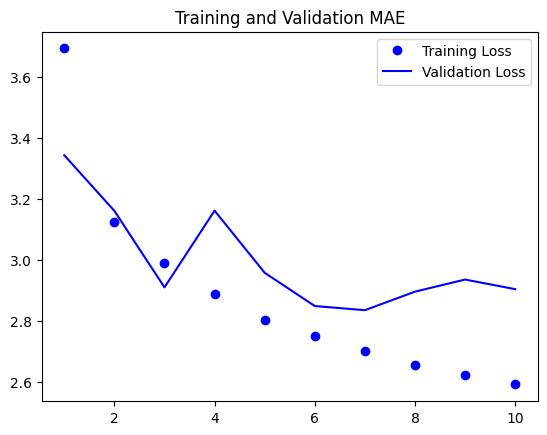

In [15]:
loss     = history.history['mae']
val_loss = history.history['val_mae']
epochs   = range(1, len(loss) +1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

In [17]:
inputs  = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x       = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model   = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras" ,save_best_only=True)
]

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

history = model.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset,
          callbacks=callbacks)

model = keras.models.load_model('jena_lstm.keras')
print(f"Test MAE {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - loss: 74.5879 - mae: 6.6122 - val_loss: 12.7406 - val_mae: 2.7105
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - loss: 12.0469 - mae: 2.6755 - val_loss: 9.4326 - val_mae: 2.3996
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 10.1346 - mae: 2.4737 - val_loss: 9.8266 - val_mae: 2.4287
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - loss: 9.6133 - mae: 2.4051 - val_loss: 10.0710 - val_mae: 2.4552
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - loss: 9.2366 - mae: 2.3608 - val_loss: 9.9919 - val_mae: 2.4463
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 8.9620 - mae: 2.3264 - val_loss: 9.9927 - val_mae: 2.4549
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 8.7219 - mae: 2.2993 - val_loss: 9.9158 - val_mae: 2.4572
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - loss: 8.4799 - mae: 2.2680 - val_loss: 10.2535 - val_mae: 2.4898
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━

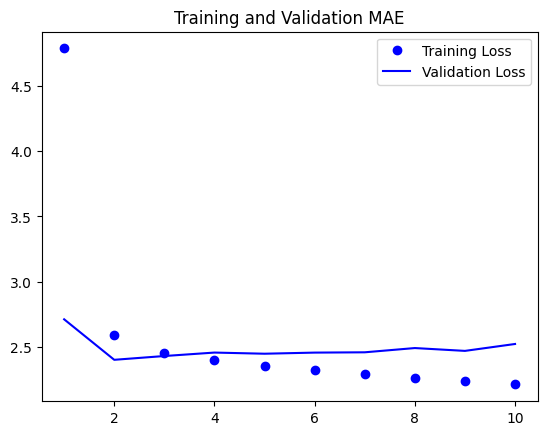

In [18]:
loss     = history.history['mae']
val_loss = history.history['val_mae']
epochs   = range(1, len(loss) +1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

In [19]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,004 (15.64 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,003 (7.83 KB)

In [24]:
inputs  = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x       = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x       = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model   = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras" ,save_best_only=True)
]

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

history = model.fit(train_dataset,
          epochs=50,
          validation_data=val_dataset,
          callbacks=callbacks)

model = keras.models.load_model('jena_lstm_dropout.keras')
print(f"Test MAE {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 316s 383ms/step - loss: 52.7832 - mae: 5.3585 - val_loss: 9.6324 - val_mae: 2.4121
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 313s 381ms/step - loss: 15.3611 - mae: 3.0440 - val_loss: 9.2268 - val_mae: 2.3612
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 315s 385ms/step - loss: 14.3853 - mae: 2.9496 - val_loss: 9.0699 - val_mae: 2.3383
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 315s 384ms/step - loss: 13.7685 - mae: 2.8839 - val_loss: 8.9099 - val_mae: 2.3160
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 323s 386ms/step - loss: 13.4056 - mae: 2.8451 - val_loss: 8.9246 - val_mae: 2.3120
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 313s 382ms/step - loss: 13.0652 - mae: 2.8058 - val_loss: 8.9249 - val_mae: 2.3094
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 314s 383ms/step - loss: 12.7168 - mae: 2.7720 - val_loss: 8.8967 - val_mae: 2.3040
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 307s 375ms/step - loss: 12.4994 - mae: 2.7460 - val_loss: 8.9495 - val_mae: 2.3082
Epoch 9/50
819/8

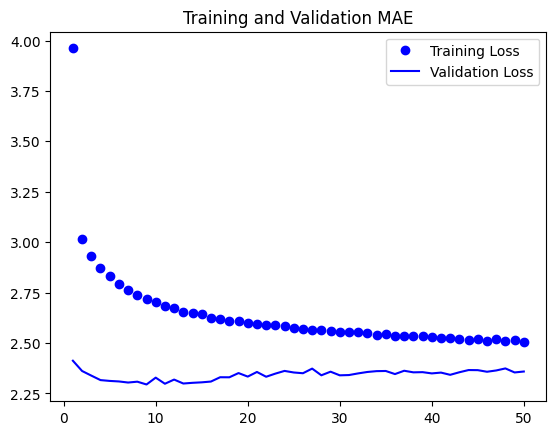

In [25]:
loss     = history.history['mae']
val_loss = history.history['val_mae']
epochs   = range(1, len(loss) +1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

In [ ]:
inputs  = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x       = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x       = layers.GRU(32, recurrent_droput=0.5)
x       = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model   = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras" ,save_best_only=True)
]

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

history = model.fit(train_dataset,
          epochs=50,
          validation_data=val_dataset,
          callbacks=callbacks)

model = keras.models.load_model('jena_stacked_gru_dropout.keras')
print(f"Test MAE {model.evaluate(test_dataset)[1]:.2f}")